<a href="https://colab.research.google.com/github/ksydata/DataAnalysis-with-Kaggle-Dacon/blob/main/DataAnalysis%26Utilization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **데이터 분석 및 활용 Australian Housing Prices 데이터 분석 과제**

The dataset contains information on 1000 properties in Australia, including location, size, price, and other details



```
1. Kaggle notebook의 GCS(Google Cloud Storage) PATH를 Collab에서 경로 지정

!pip install kaggle --upgrade
!pip install gcsfs
    # 구글 클라우드 스토리지 경로를 불러오기 위해 설치
from kaggle_datasets import KaggleDatasets
GCS_DS_PATH = KaggleDatasets().get_gcs_path("RealEstateAU_1000_Samples")
print(GCS_DS_PATH)
    # Kaggle notebook의 GCS(Google Cloud Storage) PATH를 Collab에서 불러옴
GCS_DS_PATH = "gs://'''Kaggle에서 복사한 경로 붙여넣기'''
train = pd.read_csv(GCS_DS_PATH + "/train.csv")
```





```
2. kaggle.json 위치변경 및 실행

!pip install -q kaggle
    # Kaggle API 설치
!mkdir -p ~/.kaggle
    # Kaggle directory 만들기
from google.colab import files
    # google collab API key 불러오기
uploaded = files.upload
    # 다운로드한 kaggle.json file 업로드

! cp kaggle.json ~/.kaggle
    # Kaggle directory의 API key 복사 
!chmod 600 ~/.kaggle/kaggle.json 
    # disable API key 
    # {"username":"sooyeonknunsong","key":"6f920cdd3a94110643504ef606a7af8a"}
!kaggle datasets download -d thedevastator/australian-housing-data-1000-properties-sampled
    # 데이터 셋 다운로드
!unzip -q /content/australian-housing-data-1000-properties-sampled.zip
    # 파일 압축 풀기
```



In [1697]:
import pandas as pd
import missingno as msno
import re
import numpy as np

from sklearn import *
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

import rpy2.robjects as robjects
from sklearn.ensemble import RandomForestClassifier

In [1698]:
HP = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/RealEstateAU_1000_Samples.csv", index_col = 0,  na_values = ["NaN"])
    # Australian Housing Price pandas.DataFrame

In [1699]:
CodeBook = pd.DataFrame({"features" :
                         ["breadcrumb", "category_name", "property_type", "building_size", "land_size", "preferred_size","open_date",
                         "listing_agency", "price", "location_number", "location_type",
                         "location_name", "address", "address_1", "city", "state", "zip_code", "phone",
                         "latitude", "longitude", "product_depth", "bedroom_count", "bathroom_count", "parking_count", "RunDate"],
                         
                         "descripts" : 
                         ["A breadcrumb is a text trail that shows the user's location within a website. (String)", 
                         "The name of the category that the listing belongs to. (String)",
                         "The type of property being listed. (String)",
                         "The size of the property's building, in square meters. (Numeric)",
                         "The size of the property's land, in square meters. (Numeric)",
                         "The preferred size of the property, in square meters. (Numeric)",
                         "The date that the property was first listed for sale. (Date)",
                         "The agency that is listing the property. (String)",
                         "The listing price of the property. (Numeric)",
                         "The number that corresponds to the property's location. (Numeric)",
                         "The type of location that the property is in. (String)",
                         "The name of the location that the property is in. (String)",
                         "The property's address. (String)",
                         "The first line of the property's address. (String)",
                         "The city that the property is located in. (String)",
                         "The state that the property is located in. (String)",
                         "The zip code that the property is located in. (String)",
                         "The listing agent's phone number. (String)",
                         "The property's latitude. (Numeric)",
                         "The property's longitude. (Numeric)",
                         "The depth of the product. (Numeric)",
                         "The number of bedrooms in the property. (Numeric)",
                         "The number of bathrooms in the property. (Numeric)",
                         "The number of parking spaces in the property. (Numeric)",
                         "The date that the listing was last updated. (Date)"]
})

In [1700]:
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_row", 10)
CodeBook

,features,descripts
0,breadcrumb,A breadcrumb is a text trail that shows the us...
1,category_name,The name of the category that the listing belo...
2,property_type,The type of property being listed. (String)
3,building_size,"The size of the property's building, in square..."
4,land_size,"The size of the property's land, in square met..."
...,...,...
20,product_depth,The depth of the product. (Numeric)
21,bedroom_count,The number of bedrooms in the property. (Numeric)
22,bathroom_count,The number of bathrooms in the property. (Nume...
23,parking_count,The number of parking spaces in the property. ...


In [1701]:
HP.set_index("TID", inplace=True)
    # 인덱스(행 번호)를 TID 열로 지정

In [1702]:
HP.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1350988 to 1351987
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   breadcrumb       1000 non-null   object 
 1   category_name    1000 non-null   object 
 2   property_type    1000 non-null   object 
 3   building_size    280 non-null    object 
 4   land_size        533 non-null    object 
 5   preferred_size   609 non-null    object 
 6   open_date        302 non-null    object 
 7   listing_agency   1000 non-null   object 
 8   price            1000 non-null   object 
 9   location_number  1000 non-null   int64  
 10  location_type    1000 non-null   object 
 11  location_name    1000 non-null   object 
 12  address          988 non-null    object 
 13  address_1        988 non-null    object 
 14  city             1000 non-null   object 
 15  state            1000 non-null   object 
 16  zip_code         1000 non-null   int64  
 17  phone

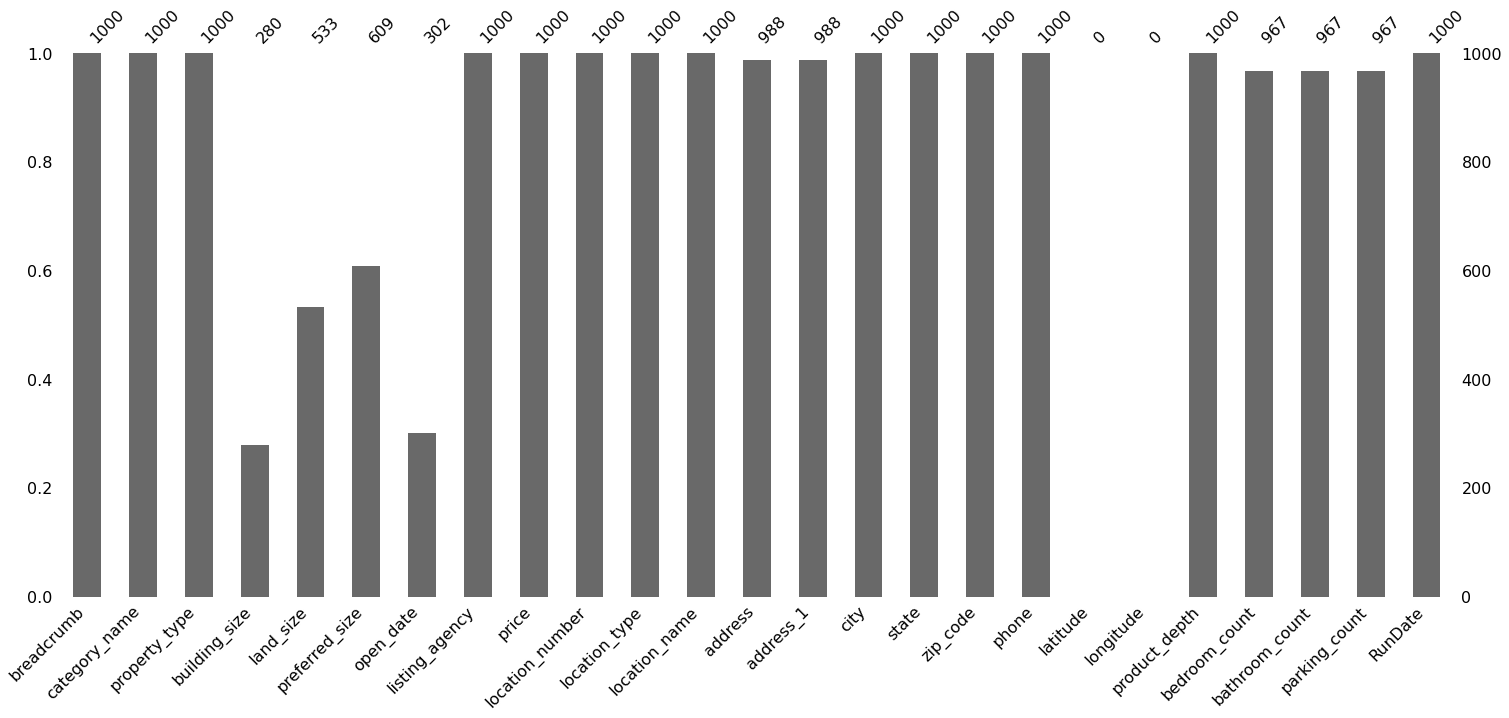

In [1703]:
msno.bar(HP)

문자열의 $ 제거 및 문자형에서 연속형으로 자료형 변환

* building size
* land_size
* preferred_size
* price
* product_depth


결측값 대체하는 보간법으로 MICE(다중대체법), KNN imputer(k-최근접 이웃 평균값), 다항식 다중선형회귀 예측값 중 선택
* building size
* land_size
* preferred_size

* bedroom_count
* bathroom_count
* parking_count

결측값 대체가 어려운 변수의 행(관측값) 제거
* address
* address_1

결측값 대체가 어려운 변수의 열 제거
* open_date
* latitude
* longitude

날짜형 변수인 RunDate의 시계열 데이터 결측값을 대체하는 보간법

In [1704]:
pd.set_option("display.max_columns", None)
HP

,breadcrumb,category_name,property_type,building_size,land_size,preferred_size,open_date,listing_agency,price,location_number,location_type,location_name,address,address_1,city,state,zip_code,phone,latitude,longitude,product_depth,bedroom_count,bathroom_count,parking_count,RunDate
TID,,,,,,,,,,,,,,,,,,,,,,,,,
1350988,Buy>NT>DARWIN CITY,Real Estate & Property for sale in DARWIN CITY...,House,NaN,NaN,NaN,Added 2 hours ago,Professionals - DARWIN CITY,"$435,000",139468611,Buy,"$435,000","44 Woods Street, Darwin City, NT 0800",44 Woods Street,Darwin City,NT,800,08 8941 8289,NaN,NaN,premiere,2.0,1.0,1.0,2022-05-27 15:54:05
1350989,Buy>NT>DARWIN CITY,Real Estate & Property for sale in DARWIN CITY...,Apartment,171m²,NaN,171m²,Added 7 hours ago,Nick Mousellis Real Estate - Eview Group Member,"Offers Over $320,000",139463755,Buy,"Offers Over $320,000","14/14 Dashwood Place, Darwin City, NT 0800",14/14 Dashwood Place,Darwin City,NT,800,0411724000,NaN,NaN,premiere,3.0,2.0,2.0,2022-05-27 15:54:05
1350990,Buy>NT>DARWIN CITY,Real Estate & Property for sale in DARWIN CITY...,Unit,NaN,NaN,NaN,Added 22 hours ago,Habitat Real Estate - THE GARDENS,"$310,000",139462495,Buy,"$310,000","13/86 Woods Street, Darwin City, NT 0800",13/86 Woods Street,Darwin City,NT,800,08 8981 0080,NaN,NaN,premiere,2.0,1.0,1.0,2022-05-27 15:54:05
1350991,Buy>NT>DARWIN CITY,Real Estate & Property for sale in DARWIN CITY...,House,NaN,NaN,NaN,Added yesterday,Ray White - NIGHTCLIFF,"$259,000",139451679,Buy,"$259,000","1309/43B Knuckey Street, Darwin City, NT 0800",1309/43B Knuckey Street,Darwin City,NT,800,08 8982 2403,NaN,NaN,premiere,1.0,1.0,0.0,2022-05-27 15:54:05
1350992,Buy>NT>DARWIN CITY,Real Estate & Property for sale in DARWIN CITY...,Unit,201m²,NaN,201m²,Added yesterday,Carol Need Real Estate - Fannie Bay,"$439,000",139433803,Buy,"$439,000","3/10 McLachlan Street, Darwin City, NT 0800",3/10 McLachlan Street,Darwin City,NT,800,0418885966,NaN,NaN,premiere,3.0,2.0,2.0,2022-05-27 15:54:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351983,Buy>NT>DARWIN,"Real Estate & Property for sale in DARWIN, NT ...",House,NaN,9.17ha,9.17ha,Under offer,United Realty NT - Parap,2 Residence,138346247,Buy,2 Residence,"70 Hinton Rd, Virginia, NT 0834",70 Hinton Rd,Virginia,NT,834,08 8981 2666,NaN,NaN,feature,4.0,3.0,6.0,2022-05-27 15:54:05
1351984,Buy>NT>DARWIN,"Real Estate & Property for sale in DARWIN, NT ...",House,203m²,600m²,600m²,NaN,Kassiou Constructions - HOWARD SPRINGS,"$601,000",138333062,Buy,"$601,000","Lot 6076 Gregg Road, Humpty Doo, NT 0836",Lot 6076 Gregg Road,Humpty Doo,NT,836,08 89834326,NaN,NaN,standard,4.0,2.0,2.0,2022-05-27 15:54:05
1351985,Buy>NT>DARWIN,"Real Estate & Property for sale in DARWIN, NT ...",House,209.6m²,800m²,800m²,NaN,Kassiou Constructions - HOWARD SPRINGS,"$655,000",138333058,Buy,"$655,000","Lot 6031 Pankhurst Street, Humpty Doo, NT 0836",Lot 6031 Pankhurst Street,Humpty Doo,NT,836,08 89834326,NaN,NaN,standard,4.0,2.0,2.0,2022-05-27 15:54:05


#### 결측값 대체가 어려운 변수의 열 제거
* open_date
* latitude
* longitude

In [1705]:
HP.drop(["open_date", "latitude", "longitude"], axis = 1, inplace = True)
    # 결측값 대체가 어려운 변수 제거

### 문자열의 $ 제거 및 문자형에서 연속형으로 자료형 변환

* building size
* land_size
* preferred_size
* price
* product_depth

In [ ]:
HP.building_size.unique

<bound method Series.unique of TID
1350988        NaN
1350989      171m²
1350990        NaN
1350991        NaN
1350992      201m²
            ...   
1351983        NaN
1351984      203m²
1351985    209.6m²
1351986      180m²
1351987      120m²
Name: building_size, Length: 1000, dtype: object>

In [1706]:
pd.set_option("display.max_row", 10)
HP.building_size.str.extract(r"(ha)") == True
  # HP 데이터프레임의 building_size 열의 r"(ha)" 헥타르가 포함된 행 출력 (True False)
HP["building_size"] = HP["building_size"].str.replace("m²", "")
HP["building_size"] = HP["building_size"].str.replace(",", "")
  # 헥타르가 포함된 행 없으므로 (False) m²단위 제거하고 float로 자료형 변환
HP["building_size"] = HP["building_size"].astype("float")

In [1707]:
HP["land_size"] = HP["land_size"].str.replace("m²", "")

In [1708]:
HP["land_size"] = HP["land_size"].str.replace(",", "")

In [1709]:
HP.land_size.str.contains(r"(m²)")

<ipython-input-1709-1cf467fc879d>:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  HP.land_size.str.contains(r"(m²)")


TID
1350988      NaN
1350989      NaN
1350990      NaN
1350991      NaN
1350992      NaN
           ...  
1351983    False
1351984    False
1351985    False
1351986    False
1351987      NaN
Name: land_size, Length: 1000, dtype: object

In [1710]:
HP["preferred_size"] = HP["preferred_size"].str.replace("m²", "")

In [1711]:
HP["preferred_size"] = HP["preferred_size"].str.replace(",", "")

In [1712]:
pd.set_option("display.max_row", None)
HP[HP.land_size.str.contains(r"(ha)") == True].index.values
    # ha와 m²의 단위 차이
    # 헥타르(hectare, ㏊)는 10,000 제곱미터(100m×100m)
    # 헥타르 단위의 land_size 또는 preferred_size를 이상치로 판정하고 결측값 NaN 처리

<ipython-input-1712-dadee000b892>:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  HP[HP.land_size.str.contains(r"(ha)") == True].index.values


array([1351134, 1351186, 1351197, 1351248, 1351263, 1351279, 1351283,
       1351306, 1351312, 1351326, 1351332, 1351334, 1351340, 1351345,
       1351364, 1351373, 1351391, 1351392, 1351415, 1351479, 1351527,
       1351550, 1351553, 1351557, 1351582, 1351595, 1351607, 1351628,
       1351632, 1351658, 1351659, 1351662, 1351677, 1351699, 1351739,
       1351777, 1351815, 1351934, 1351936, 1351937, 1351942, 1351957,
       1351962, 1351969, 1351983])

In [1713]:
land_size_ha = HP[HP.land_size.str.contains(r"(ha)") == True].index.values

<ipython-input-1713-1a0de7b4bb02>:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  land_size_ha = HP[HP.land_size.str.contains(r"(ha)") == True].index.values


In [1714]:
len(land_size_ha)

45

In [1715]:
HP[HP.preferred_size.str.contains(r"(ha)") == True].index.values

<ipython-input-1715-3bd4a3c0c02a>:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  HP[HP.preferred_size.str.contains(r"(ha)") == True].index.values


array([1351186, 1351197, 1351248, 1351263, 1351279, 1351283, 1351306,
       1351312, 1351326, 1351332, 1351334, 1351340, 1351345, 1351364,
       1351373, 1351391, 1351392, 1351415, 1351479, 1351527, 1351550,
       1351553, 1351557, 1351582, 1351595, 1351607, 1351628, 1351632,
       1351658, 1351659, 1351662, 1351677, 1351699, 1351739, 1351777,
       1351815, 1351934, 1351936, 1351937, 1351942, 1351957, 1351962,
       1351969, 1351983])

In [1716]:
preferred_size_ha = HP[HP.preferred_size.str.contains(r"(ha)") == True].index.values

<ipython-input-1716-1564dd04db57>:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  preferred_size_ha = HP[HP.preferred_size.str.contains(r"(ha)") == True].index.values


In [1717]:
len(preferred_size_ha)

44

In [1718]:
land_size_ha_list = []

for i in range(0, 45, 1):
    land_size_ha_list.append(land_size_ha[i])
    if i == 44: 
      print(type(land_size_ha_list))
      print(land_size_ha_list)
    else: pass

<class 'list'>
[1351134, 1351186, 1351197, 1351248, 1351263, 1351279, 1351283, 1351306, 1351312, 1351326, 1351332, 1351334, 1351340, 1351345, 1351364, 1351373, 1351391, 1351392, 1351415, 1351479, 1351527, 1351550, 1351553, 1351557, 1351582, 1351595, 1351607, 1351628, 1351632, 1351658, 1351659, 1351662, 1351677, 1351699, 1351739, 1351777, 1351815, 1351934, 1351936, 1351937, 1351942, 1351957, 1351962, 1351969, 1351983]


In [1719]:
preferred_size_ha_list = []

for i in range(0, 44, 1):
    preferred_size_ha_list.append(preferred_size_ha[i])
    if i == 43: 
      print(type(preferred_size_ha_list))
      print(preferred_size_ha_list)
    else: pass

<class 'list'>
[1351186, 1351197, 1351248, 1351263, 1351279, 1351283, 1351306, 1351312, 1351326, 1351332, 1351334, 1351340, 1351345, 1351364, 1351373, 1351391, 1351392, 1351415, 1351479, 1351527, 1351550, 1351553, 1351557, 1351582, 1351595, 1351607, 1351628, 1351632, 1351658, 1351659, 1351662, 1351677, 1351699, 1351739, 1351777, 1351815, 1351934, 1351936, 1351937, 1351942, 1351957, 1351962, 1351969, 1351983]


In [1720]:
# [x for y in land_size_ha_list for x in preferred_size_ha_list if y in x]  
    # 두 리스트의 공통된 행 번호 추출
    # if str.find("") != m²
    # preprocessed_text = re.sub('[^a-zA-Z]', ' ', text)

In [1721]:
HP.at[land_size_ha_list, "land_size"] = "NaN"
    # 헥타르 단위의 land_size를 이상치로 판정하고 결측값 NaN 처리

In [1722]:
HP.at[preferred_size_ha_list, "preferred_size"] = "NaN"
    # 헥타르 단위의 preferred_size를 이상치로 판정하고 결측값 NaN 처리

In [1723]:
HP = HP.astype({
    "land_size":"float",
    "preferred_size":"float"
})

In [1724]:
HP.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1350988 to 1351987
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   breadcrumb       1000 non-null   object 
 1   category_name    1000 non-null   object 
 2   property_type    1000 non-null   object 
 3   building_size    280 non-null    float64
 4   land_size        488 non-null    float64
 5   preferred_size   565 non-null    float64
 6   listing_agency   1000 non-null   object 
 7   price            1000 non-null   object 
 8   location_number  1000 non-null   int64  
 9   location_type    1000 non-null   object 
 10  location_name    1000 non-null   object 
 11  address          988 non-null    object 
 12  address_1        988 non-null    object 
 13  city             1000 non-null   object 
 14  state            1000 non-null   object 
 15  zip_code         1000 non-null   int64  
 16  phone            1000 non-null   object 
 17  produ

In [1725]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_row", 10)
HP
   # location_name 변수의 관측값(변량)과 price 변수의 관측값이 동일한 문제

,breadcrumb,category_name,property_type,building_size,land_size,preferred_size,listing_agency,price,location_number,location_type,location_name,address,address_1,city,state,zip_code,phone,product_depth,bedroom_count,bathroom_count,parking_count,RunDate
TID,,,,,,,,,,,,,,,,,,,,,,
1350988,Buy>NT>DARWIN CITY,Real Estate & Property for sale in DARWIN CITY...,House,NaN,NaN,NaN,Professionals - DARWIN CITY,"$435,000",139468611,Buy,"$435,000","44 Woods Street, Darwin City, NT 0800",44 Woods Street,Darwin City,NT,800,08 8941 8289,premiere,2.0,1.0,1.0,2022-05-27 15:54:05
1350989,Buy>NT>DARWIN CITY,Real Estate & Property for sale in DARWIN CITY...,Apartment,171.0,NaN,171.0,Nick Mousellis Real Estate - Eview Group Member,"Offers Over $320,000",139463755,Buy,"Offers Over $320,000","14/14 Dashwood Place, Darwin City, NT 0800",14/14 Dashwood Place,Darwin City,NT,800,0411724000,premiere,3.0,2.0,2.0,2022-05-27 15:54:05
1350990,Buy>NT>DARWIN CITY,Real Estate & Property for sale in DARWIN CITY...,Unit,NaN,NaN,NaN,Habitat Real Estate - THE GARDENS,"$310,000",139462495,Buy,"$310,000","13/86 Woods Street, Darwin City, NT 0800",13/86 Woods Street,Darwin City,NT,800,08 8981 0080,premiere,2.0,1.0,1.0,2022-05-27 15:54:05
1350991,Buy>NT>DARWIN CITY,Real Estate & Property for sale in DARWIN CITY...,House,NaN,NaN,NaN,Ray White - NIGHTCLIFF,"$259,000",139451679,Buy,"$259,000","1309/43B Knuckey Street, Darwin City, NT 0800",1309/43B Knuckey Street,Darwin City,NT,800,08 8982 2403,premiere,1.0,1.0,0.0,2022-05-27 15:54:05
1350992,Buy>NT>DARWIN CITY,Real Estate & Property for sale in DARWIN CITY...,Unit,201.0,NaN,201.0,Carol Need Real Estate - Fannie Bay,"$439,000",139433803,Buy,"$439,000","3/10 McLachlan Street, Darwin City, NT 0800",3/10 McLachlan Street,Darwin City,NT,800,0418885966,premiere,3.0,2.0,2.0,2022-05-27 15:54:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351983,Buy>NT>DARWIN,"Real Estate & Property for sale in DARWIN, NT ...",House,NaN,NaN,NaN,United Realty NT - Parap,2 Residence,138346247,Buy,2 Residence,"70 Hinton Rd, Virginia, NT 0834",70 Hinton Rd,Virginia,NT,834,08 8981 2666,feature,4.0,3.0,6.0,2022-05-27 15:54:05
1351984,Buy>NT>DARWIN,"Real Estate & Property for sale in DARWIN, NT ...",House,203.0,600.0,600.0,Kassiou Constructions - HOWARD SPRINGS,"$601,000",138333062,Buy,"$601,000","Lot 6076 Gregg Road, Humpty Doo, NT 0836",Lot 6076 Gregg Road,Humpty Doo,NT,836,08 89834326,standard,4.0,2.0,2.0,2022-05-27 15:54:05
1351985,Buy>NT>DARWIN,"Real Estate & Property for sale in DARWIN, NT ...",House,209.6,800.0,800.0,Kassiou Constructions - HOWARD SPRINGS,"$655,000",138333058,Buy,"$655,000","Lot 6031 Pankhurst Street, Humpty Doo, NT 0836",Lot 6031 Pankhurst Street,Humpty Doo,NT,836,08 89834326,standard,4.0,2.0,2.0,2022-05-27 15:54:05


In [1726]:
HP.drop("location_name", axis = 1, inplace = True)
   # location_name이 잘못 저장되었다고 판단 하에 location_name 변수 열 제거

In [1727]:
HP[HP.price.str.contains(r"(2 Residence)") == True].index.values

<ipython-input-1727-6821adb4a86f>:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  HP[HP.price.str.contains(r"(2 Residence)") == True].index.values


array([1351983])

In [1728]:
# Trial & Error

# HP["price"] = HP["price"].str.replace("369 000", "369000")
'''
HP["price"] = HP["price"].str.strip()
HP["price"] = HP["price"].str.lstrip()
    # 좌우 공백 제거
HP["price"] = HP["price"].str.replace("$", "")
HP["price"] = HP["price"].str.replace(",", "")
HP["price"] = HP["price"].str.replace("+", "")
    # price 변수의 문자열 $ 및 , 화폐 단위 제거
HP["price"] = HP["price"].str.replace("Offersover", "")
HP["price"] = HP["price"].str.replace("Offers over ", "")
HP["price"] = HP["price"].str.replace("Offers Over ", "")
HP["price"] = HP["price"].str.replace("OversOver", "")
HP["price"] = HP["price"].str.replace("Overs Over", "")
HP["price"] = HP["price"].str.replace("Considered", "")
HP["price"] = HP["price"].str.replace("PRICEGUIDE", "")
HP["price"] = HP["price"].str.replace("PRICE GUIDE", "")
HP["price"] = HP["price"].str.replace("FASTRAK", "NaN")
HP["price"] = HP["price"].str.replace("UNDERCONTRACT", "NaN")
HP["price"] = HP["price"].str.replace("UNDER CONTRACT", "NaN")
HP["price"] = HP["price"].str.replace("2Residence", "NaN")
HP["price"] = HP["price"].str.replace("OpennNegotiation", "NaN")
HP["price"] = HP["price"].str.replace("Openn Negotiation", "NaN")
    # Offers over 문자열 및 2 Residence 집 가격과 무관한 바 제거
'''

# HP[HP.price.isnull()]
    # [ValueError] invalid literal for int() with base 10: 'NaN' 

# HP[HP.price.str.contains(r"(NaN)") == True].index.values
# price_NaN = HP[HP.price.str.contains(r"(NaN)") == True].index.values
# len(price_NaN)
'''
price_NaN_list = []

for i in range(0, 15, 1):
    price_NaN_list.append(price_NaN[i])
    if i == 43: 
      print(type(price_NaN_list))
      print(price_NaN_list)
    else: pass
'''
# HP.at[price_NaN_list, "price"] = "NaN"

# HP["price"] = HP["price"].str.replace(pat = r'.',repl = r' ', regex=True)
# HP["price"] = re.sub(r"[^0-9]", "", HP["price"])

'\nprice_NaN_list = []\n\nfor i in range(0, 15, 1):\n    price_NaN_list.append(price_NaN[i])\n    if i == 43: \n      print(type(price_NaN_list))\n      print(price_NaN_list)\n    else: pass\n'

In [1729]:
HP.price = HP.price.str.extract('(\d+)')

In [1730]:
HP["price"] = HP["price"].astype("float")

In [1731]:
HP.product_depth = HP.product_depth.str.extract('(\d+)')

In [1732]:
HP["product_depth"] = HP["product_depth"].astype("float")
    # product_depth는 문자 제거 후 숫자만 남기면 모두 NaN으로 결측인바 변수 열 제거 

In [1733]:
HP.drop(["product_depth"], axis = 1, inplace = True)

### 자료형 변환(문자형에서 범주형)

In [1734]:
HP["RunDate"] = pd.to_datetime(HP["RunDate"])

In [1735]:
HP = HP.sort_values(by = "RunDate") 

In [1736]:
HP["breadcrumb"].unique()
    # category
    # 웹사이트 내에서 사용자의 위치를 보여주는 텍스트 흔적

array(['Buy>NT>DARWIN CITY', 'Buy>NT>DARWIN'], dtype=object)

In [1737]:
HP["category_name"].unique()
    # category & TARGET variable

array(['Real Estate & Property for sale in DARWIN CITY, NT 0800',
       'Real Estate & Property for sale in DARWIN, NT 0801'], dtype=object)

In [1738]:
HP["property_type"].unique()
    # category

array(['House', 'Duplex/Semi-detached', 'Unit', 'Villa', 'Apartment',
       'Townhouse', 'Acreage', 'Residential Land', 'Warehouse',
       'Block Of Units', 'Lifestyle', 'Studio', 'Other'], dtype=object)

In [1739]:
HP["location_type"].unique()
   # 유형이 Buy 하나인바 변수 열 제거
HP.drop("location_type", axis = 1, inplace = True)

In [1740]:
# HP["listing_agency"].unique()
    # object

In [1741]:
HP["city"].unique()
    # category

array(['Darwin City', 'Bakewell', 'Moulden', 'Jingili', 'Larrakeyah',
       'Stuart Park', 'Rosebery', 'Leanyer', 'Gray', 'Johnston',
       'Wagaman', 'Howard Springs', 'Alawa', 'Nightcliff', 'Anula',
       'Berry Springs', 'Cullen Bay', 'Coconut Grove', 'Bellamack',
       'Driver', 'Fannie Bay', 'Parap', 'Woodroffe', 'Malak', 'Farrar',
       'Gunn', 'Rapid Creek', 'Millner', 'Girraween', 'Muirhead',
       'Ludmilla', 'Humpty Doo', 'Bayview', 'Berrimah', 'Wanguri',
       'Durack', 'Tiwi', 'Zuccoli', 'Karama', 'Herbert', 'Moil', 'Lyons',
       'Woolner', 'Brinkin', 'Wulagi', 'The Gardens', 'Knuckey Lagoon',
       'Virginia', 'Nakara', 'Marlow Lagoon', 'Coolalinga', 'Bees Creek',
       'Rosebery Heights', 'Marrara', 'The Narrows', 'Lee Point'],
      dtype=object)

In [1742]:
HP["state"].unique()
    # 유형이 Buy 하나인바 변수 열 제거
HP.drop("state", axis = 1, inplace = True)

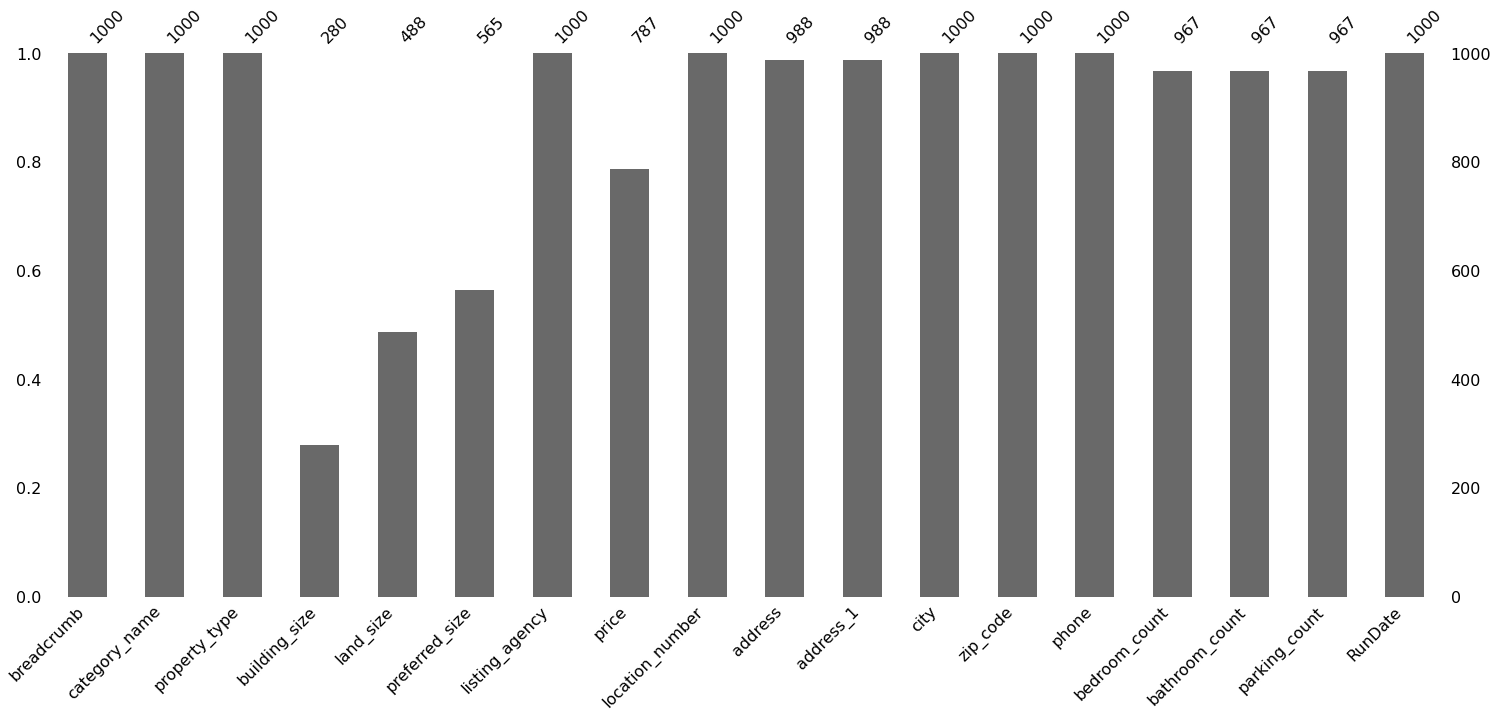

In [1743]:
msno.bar(HP)

In [1744]:
HP = HP.astype({
    "breadcrumb":"category",
    "category_name":"category",
    "property_type":"category",
    "city":"category"
})

In [1745]:
HP.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1350988 to 1351987
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   breadcrumb       1000 non-null   category      
 1   category_name    1000 non-null   category      
 2   property_type    1000 non-null   category      
 3   building_size    280 non-null    float64       
 4   land_size        488 non-null    float64       
 5   preferred_size   565 non-null    float64       
 6   listing_agency   1000 non-null   object        
 7   price            787 non-null    float64       
 8   location_number  1000 non-null   int64         
 9   address          988 non-null    object        
 10  address_1        988 non-null    object        
 11  city             1000 non-null   category      
 12  zip_code         1000 non-null   int64         
 13  phone            1000 non-null   object        
 14  bedroom_count    967 non-null  

### 연속형 변수 상관분석 후 KNN을 이용한 결측값 예측하여 보간/대체

<ipython-input-1746-b7e87e712c32>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(HP.corr(), dtype = np.bool)


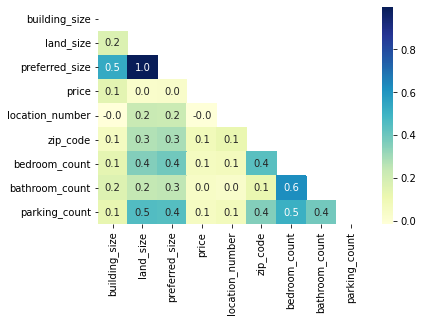

In [1746]:
corr = HP.corr()
mask = np.zeros_like(HP.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
    # 상관분석 히트맵 삼각형 마스크(위 쪽 삼각형에 True, 아래 삼각형에 False)
sns.heatmap(data = corr, annot = True, fmt = ".1f", cmap = "YlGnBu", mask = mask)



```
* 상관분석 결과 building_size와의 상관계수가 0.4 이상인 prefered를 이용하여 결측값 대체
* 상관분석 결과 land_size, preferred_size와의 상관계수가 0.4 이상인 parking_count, bedroom_count를 이용하여 결측값 대체
```



In [1747]:
NA_impute = KNNImputer()
    # NA값의 최근접 k개의 평균으로 결측값을 대체하는 k-nearest neighbor 보간법

In [1748]:
numeric_col = HP.select_dtypes(include = ["int64", "float64"]).columns.values

In [1749]:
numeric_col_list = []
for i in range(0, 9, 1):
  numeric_col_list.append(numeric_col[i])

In [1750]:
numeric_col_list.pop(5)

'zip_code'

In [1751]:
print(numeric_col_list, end = ",")

['building_size', 'land_size', 'preferred_size', 'price', 'location_number', 'bedroom_count', 'bathroom_count', 'parking_count'],

In [1752]:
NA_impute.fit(HP.loc[:, numeric_col_list])

for col_name in numeric_col_list:
  HP[col_name] = NA_impute.transform(HP.loc[:, numeric_col_list])

In [1753]:
HP.isnull().sum()

breadcrumb        0
category_name     0
property_type     0
building_size     0
land_size         0
                 ..
phone             0
bedroom_count     0
bathroom_count    0
parking_count     0
RunDate           0
Length: 18, dtype: int64

In [1754]:
HP = HP.dropna()
    # address와 address_1 변수의 결측값 12개는 보간하기 어려운바 12개 행 제거

### Target 변수인 category_name을 예측하기 위한 이진분류기

해당 데이터는 호주의 주택가격을 예측하는 회귀의 문제로 풀 수 있으나

데이터 분석 및 활용, 본 수업에서는 비선형 회귀분석을 다루지 않은바
분류의 문제로 예측함



```
# 범주형 변수는 원핫인코딩하지 않으면 모델링 할 수 없는 문제
    # 대안 1: 원핫인코딩
    # 대안 2: Python에서 범주형 변수에 제약이 없는 R 실행하기
        # from rpy2.robjects import r
        # import rpy2.robjects as robjects```



In [1755]:
HP_learner_DF = HP.drop(["listing_agency", "address", "address_1", "phone", "RunDate"], axis = 1)

#### 대안 2

In [1756]:
# HP_learner_DF.to_csv("/content/drive/MyDrive/HP_learner_DF.csv", index = False)
    # R에서 모델링하기 위해 csv파일로 저장

#### 대안 1

In [1757]:
HP_learner_DF = pd.get_dummies(HP_learner_DF)
HP_learner_DF

,building_size,land_size,preferred_size,price,location_number,zip_code,bedroom_count,bathroom_count,parking_count,breadcrumb_Buy>NT>DARWIN,breadcrumb_Buy>NT>DARWIN CITY,"category_name_Real Estate & Property for sale in DARWIN CITY, NT 0800","category_name_Real Estate & Property for sale in DARWIN, NT 0801",property_type_Acreage,property_type_Apartment,property_type_Block Of Units,property_type_Duplex/Semi-detached,property_type_House,property_type_Lifestyle,property_type_Other,property_type_Residential Land,property_type_Studio,property_type_Townhouse,property_type_Unit,property_type_Villa,property_type_Warehouse,city_Alawa,city_Anula,city_Bakewell,city_Bayview,city_Bees Creek,city_Bellamack,city_Berrimah,city_Berry Springs,city_Brinkin,city_Coconut Grove,city_Coolalinga,city_Cullen Bay,city_Darwin City,city_Driver,city_Durack,city_Fannie Bay,city_Farrar,city_Girraween,city_Gray,city_Gunn,city_Herbert,city_Howard Springs,city_Humpty Doo,city_Jingili,city_Johnston,city_Karama,city_Knuckey Lagoon,city_Larrakeyah,city_Leanyer,city_Lee Point,city_Ludmilla,city_Lyons,city_Malak,city_Marlow Lagoon,city_Marrara,city_Millner,city_Moil,city_Moulden,city_Muirhead,city_Nakara,city_Nightcliff,city_Parap,city_Rapid Creek,city_Rosebery,city_Rosebery Heights,city_Stuart Park,city_The Gardens,city_The Narrows,city_Tiwi,city_Virginia,city_Wagaman,city_Wanguri,city_Woodroffe,city_Woolner,city_Wulagi,city_Zuccoli
TID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1350988,225.400,225.400,225.400,225.400,225.400,800,225.400,225.400,225.400,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1351646,144.800,144.800,144.800,144.800,144.800,832,144.800,144.800,144.800,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1351647,124.000,124.000,124.000,124.000,124.000,830,124.000,124.000,124.000,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1351648,144.800,144.800,144.800,144.800,144.800,810,144.800,144.800,144.800,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1351649,111.000,111.000,111.000,111.000,111.000,820,111.000,111.000,111.000,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351327,187.000,187.000,187.000,187.000,187.000,830,187.000,187.000,187.000,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1351328,197.800,197.800,197.800,197.800,197.800,830,197.800,197.800,197.800,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1351329,197.800,197.800,197.800,197.800,197.800,832,197.800,197.800,197.800,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1758]:
HP.groupby("category_name").count()
    # Real Estate & Property for sale in DARWIN CITY, NT 0800를 1, 아니면 0

,breadcrumb,property_type,building_size,land_size,preferred_size,listing_agency,price,location_number,address,address_1,city,zip_code,phone,bedroom_count,bathroom_count,parking_count,RunDate
category_name,,,,,,,,,,,,,,,,,
"Real Estate & Property for sale in DARWIN CITY, NT 0800",183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183
"Real Estate & Property for sale in DARWIN, NT 0801",805,805,805,805,805,805,805,805,805,805,805,805,805,805,805,805,805


In [1759]:
# HP_learner_DF["category_name"] = HP_learner_DF["category_name_Real Estate & Property for sale in DARWIN CITY, NT 0800"]

In [1760]:
# HP_learner_DF.drop(["category_name_Real Estate & Property for sale in DARWIN CITY, NT 0800", "category_name_Real Estate & Property for sale in DARWIN, NT 0801"], axis = 1, inplace = True)

In [1761]:
'''
x, y = 0, 0

x = HP_learner_DF["category_name"]
    # category_name_Real Estate & Property for sale in DARWIN CITY NT 0800
    # category_name_Real Estate & Property for sale in DARWIN, NT 0801	
y = HP_learner_DF.drop("category_name", axis = 1)
'''

'\nx, y = 0, 0\n\nx = HP_learner_DF["category_name"]\n    # category_name_Real Estate & Property for sale in DARWIN CITY NT 0800\n    # category_name_Real Estate & Property for sale in DARWIN, NT 0801\t\ny = HP_learner_DF.drop("category_name", axis = 1)\n'

In [1762]:
HP_learner_DF = HP_learner_DF.astype({
    "category_name_Real Estate & Property for sale in DARWIN CITY, NT 0800":"category",
    "category_name_Real Estate & Property for sale in DARWIN, NT 0801":"category"
})

In [1763]:
x, y = 0, 0

x = HP_learner_DF.loc[:, ["category_name_Real Estate & Property for sale in DARWIN CITY, NT 0800", "category_name_Real Estate & Property for sale in DARWIN, NT 0801"]]
    # category_name_Real Estate & Property for sale in DARWIN CITY NT 0800
    # category_name_Real Estate & Property for sale in DARWIN, NT 0801	
y = HP_learner_DF.drop(["category_name_Real Estate & Property for sale in DARWIN CITY, NT 0800", "category_name_Real Estate & Property for sale in DARWIN, NT 0801"], axis = 1)

In [1764]:
y = pd.DataFrame(y)

In [1765]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 2023)

In [1766]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 2023)
    # 부스팅으로 의사결정 분류나무 1000개를 생성하여 투표하는 랜덤 포레스트

In [1767]:
rf.fit(x_train, y_train)
    # ValueError: could not convert string to float: 'Real Estate & Property for sale in DARWIN, NT 0801' 
    # ValueError: Unknown label type: 'continuous-multioutput'

ValueError: ignored